In [4]:
# Imports
from __future__ import division
import os, gzip, urllib2, csv, numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

## Clustering

* **Exercise: K-means.
In this exercise we explore K-means clustering - and we it out on the locations of the PROSTITUTION crime type. Applying a clustering method makes sense because we know from our earlier work that this crime type tends to happen in only a few locations. 
**

**Visualize the prostitution data**

In [5]:
prost_geo_data={"lat": [],"lon": []} ; Y=[]

filename = 'data/SFPD_Incidents_-_from_1_January_2003.csv.gz'

if not os.path.isfile(filename):
    import shutil
    src = urllib2.urlopen('https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD')
    with gzip.open(filename, 'wt') as f:
        shutil.copyfileobj(src, f)

with gzip.open(filename, 'rt') as f:
    for row in csv.DictReader(f):
        if row['Category'] == 'PROSTITUTION':
            if float(row['Y'])==90: # Skip some wrong values 
                continue
            prost_geo_data['lon']+=[float(row['X'])]; prost_geo_data['lat']+=[float(row['Y'])]
            Y+=[row['PdDistrict']]

max_lat, max_lon = map(max, [prost_geo_data['lat'], prost_geo_data['lon']])
min_lat, min_lon = map(min, [prost_geo_data['lat'], prost_geo_data['lon']])
bbox_center_x=(min_lat+max_lat)/2; bbox_center_y=(min_lon+max_lon)/2

In [6]:
# Bring data to correct format:
X=[[lat, lon] for lat, lon in zip(*prost_geo_data.values())]

my_range=range(2,7)

# Fit data to kmeans classifier:
kmeans=[KMeans(n_clusters=k, random_state=0).fit(X) for k in my_range]

**Explore how the total squared error changes as a function of K and identify what you think is the right number of clusers based on the knee-point in the squared error plot.**

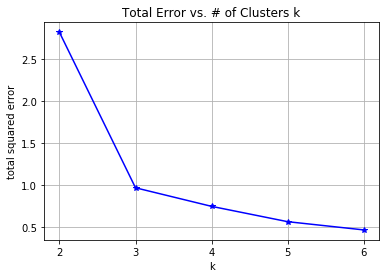

In [7]:
def squared_distance(v, w):
    """Returns sum of square differences between two vectors"""
    return np.sum((v-w)**2)

# Calculate squared clustering errors for k=2,...,10  
errors=[]
for k in my_range:
    means = kmeans[k-2].cluster_centers_
    # Shamelessly ripped off of DSFS chapter 19:
    assignments = [min(range(k), key=lambda i: squared_distance(x, means[i])) for x in X]
    errors+=[sum(squared_distance(x, means[cluster]) for x, cluster in zip(X, assignments))]
    
plt.plot(my_range, errors, 'b*-')
plt.xlabel("k")
plt.xticks(np.arange(min(my_range), max(my_range)+1, 1.0))
plt.ylabel("total squared error")
plt.title("Total Error vs. # of Clusters k")
plt.grid(True)
plt.show()

After plotting the sum of squared errors between each point and the mean of its cluster vs k, we can see that in general there is no dramatic difference as our upper y axis limit is 3. Having said that, the graph "bends" at k=3, meaning that above this k we don't get a signficant discrease in errors, it should therefore be the default k value in the visualization.

**Using Python, create a file containing the data you wish to visualize.
The datapoints you should use, is the same as for week 5, so it is all crimes with type = PROSTITUTION
Note : Think carefully about how you can minimize the size of the file containing the data. My file is around 700KB. Why is the size of the file important?**

In [8]:
centers=[]

prost_geo_data_reduced={}
for estimator in kmeans:
        n=estimator.n_clusters
        for i in range(n):
            # Extract centroid coordinates for each different k:
            center=np.ndarray.tolist(estimator.cluster_centers_)[i]
            centers+=[{'cluster': [i]*n, 'lat':center[1], 'lon':center[0], 'center':n}]
             # Store data point coordinates and their labels for different k values:           
            for index in np.where(estimator.labels_ == i)[0]:
                coord=str(X[index])
                if coord not in prost_geo_data_reduced:
                    # To avoid redundancy we are using a dict {coordinates: {k:label}}
                    prost_geo_data_reduced[coord]={n:i}
                else:  
                    prost_geo_data_reduced[coord][n]=i


with open('sf_prost_data_reduced.csv', 'w') as csvfile:
    fieldnames = ['cluster', 'lat', 'lon', 'center', 'bbox']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    # Pass bounding box coordinates
    writer.writerow({'bbox': True, 'lat': bbox_center_x, 'lon':bbox_center_y, 'center': False})
    for point in prost_geo_data_reduced:
            lon, lat=point[1:-1].split(',')
            writer.writerow({'cluster': prost_geo_data_reduced[point].values(), 'lat':lat, 'lon':lon})
    # Write centroid data last so that they show up on top of other dots:
    for center in centers:
        writer.writerow(center)

The size of the file is important because 1. it will be stored locally 2. and more importantly, it will be parsed by the browser: the larger the file, the slower the rendering of the dotted map will be.